In [59]:
#packages

import shap
import pandas as pd
import pickle
import copy
import seaborn as sns
from matplotlib import gridspec

import numpy as np
import os 
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score


In [60]:
import os
for dirname, _, filenames in os.walk('/D:/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [61]:
#load the dataset
train_full = pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/train-white.csv", sep=",")
test_full =  pd.read_csv("/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/test-white.csv", sep=",")

In [62]:
# Step 2: Prepare the data
target = "quality"
X_train = train_full.drop(columns=[target])
y_train = train_full[target]
X_test = test_full.drop(columns=[target])
y_test = test_full[target]

In [63]:
target = "quality"
X_train = train_full.drop(columns=[target])
y_train = train_full[target]

In [64]:
train_full.head()
test_full.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.8,0.67,0.30,13.0,0.290,22.0,193.0,0.99840,3.08,0.67,9.0,4
1,6.7,0.26,0.26,4.1,0.073,36.0,202.0,0.99560,3.30,0.67,9.5,5
2,5.7,0.21,0.25,1.1,0.035,26.0,81.0,0.99020,3.31,0.52,11.4,6
3,6.6,0.16,0.30,1.6,0.034,15.0,78.0,0.99200,3.38,0.44,11.2,6
4,5.4,0.53,0.16,2.7,0.036,34.0,128.0,0.98856,3.20,0.53,13.2,8


In [65]:
# Step 3: DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [66]:
X_train = copy.deepcopy(train_full.drop(columns=target))
X_test = copy.deepcopy(test_full.drop(columns=target))
y_train = train_full[target]
y_test = test_full[target]

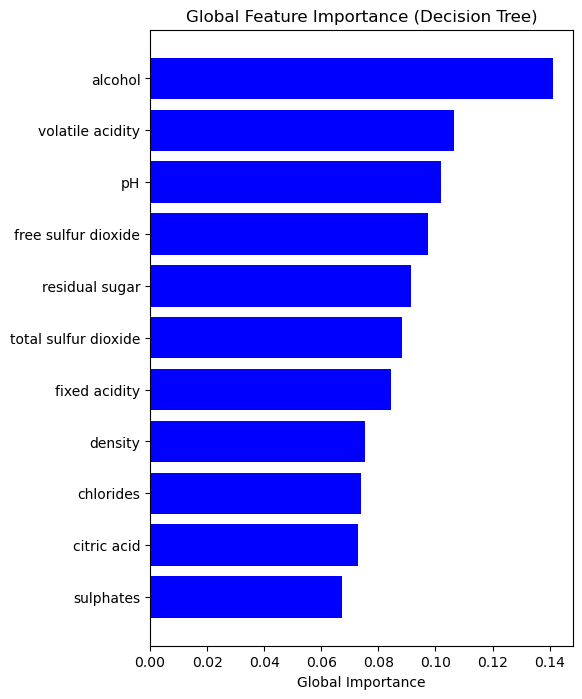

In [67]:
np.random.seed(42)

explainer = shap.TreeExplainer(model)

# Feature names
feature_names = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

shap_values = explainer.shap_values(X_test)

# class 6 (assuming class 6 corresponds to index 3 in shap_values 2 = 0, 5 = 2 , 6 = 3)
class_index = 3 
shap_values_class = shap_values[class_index]

#  Global feature importance from the DecisionTreeClassifier
tree_feature_importances = model.feature_importances_

# SHAP feature importance for a specific instance
instance_index = 3  
shap_importances_local = shap_values_class[instance_index]  

sorted_indices = np.argsort(tree_feature_importances)[::-1]

if len(shap_importances_local) != len(feature_names):
    print(f"Warning: SHAP values size {len(shap_importances_local)} does not match feature names size {len(feature_names)}")
    shap_importances_local = np.resize(shap_importances_local, len(feature_names))

# Plot 

# Global feature importance (DecisionTreeClassifier)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Global Feature Importance (Decision Tree)")
plt.barh(np.array(feature_names)[sorted_indices], tree_feature_importances[sorted_indices], color='blue')
plt.xlabel("Global Importance")
plt.gca().invert_yaxis()

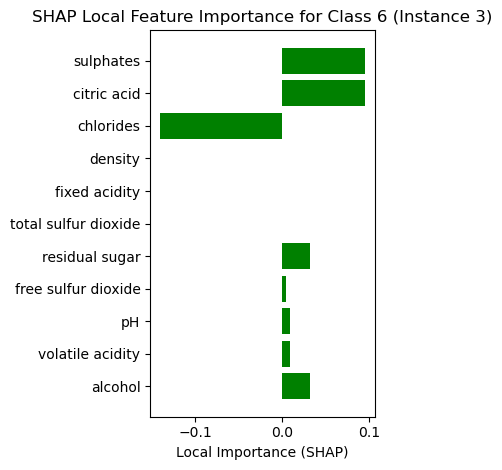

In [70]:
# Local feature importance (SHAP)
plt.subplot(1, 2, 2)
plt.title(f"SHAP Local Feature Importance for Class {class_index+3} (Instance {instance_index})")
plt.barh(np.array(feature_names)[sorted_indices], np.array(shap_importances_local)[sorted_indices], color='green')
plt.xlabel("Local Importance (SHAP)")

plt.tight_layout()
plt.show()

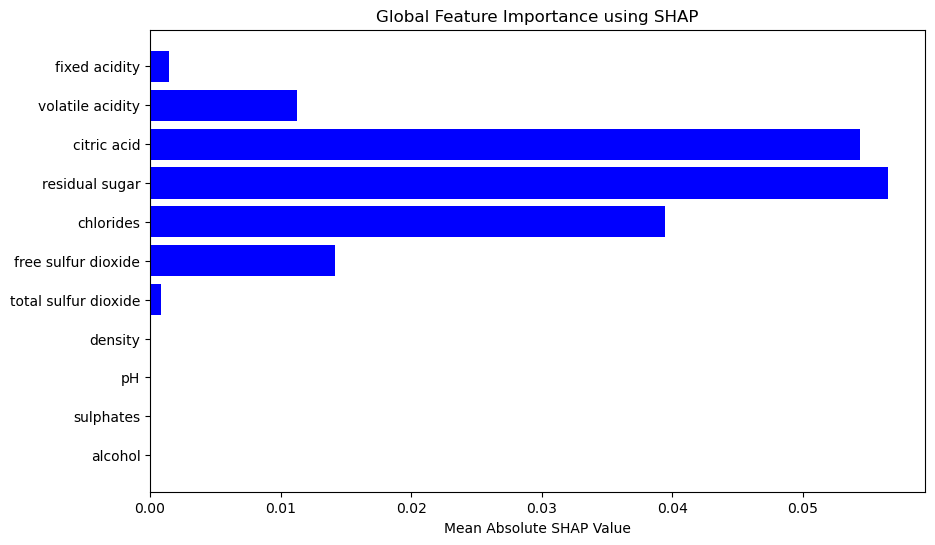

In [56]:
num_outputs = len(shap_values) 
num_features = X_test.shape[1]  
global_shap_values = np.zeros((num_outputs, num_features))

for i, shap_array in enumerate(shap_values):
    aggregated_shap = np.zeros(num_features)
    aggregated_shap[:shap_array.shape[1]] = np.mean(np.abs(shap_array), axis=0)  # Mean across instances
    global_shap_values[i] = aggregated_shap


global_shap_importance = np.mean(global_shap_values, axis=0)

# Plot
feature_names = X_test.columns.tolist()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, global_shap_importance, color='blue')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Global Feature Importance using SHAP")
plt.gca().invert_yaxis()
plt.show()



In [57]:
# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.59


In [69]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predictions using Decision Tree model
y_pred_dt = model.predict(X_test)  # Assuming 'model' is your trained Decision Tree model
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f"RMSE for Decision Tree: {rmse_dt:.2f}")

RMSE for Decision Tree: 0.83


In [58]:
np.random.seed(42)

# stability score using SHAP
def calculate_stability_score_shap(instance, explainer, epsilon=0.1, num_samples=200):

    phi_original = explainer.shap_values(instance.reshape(1, -1))[0]

    #  perturbed samples
    perturbations = np.random.normal(0, epsilon, size=(num_samples, instance.shape[0]))
    perturbed_samples = np.clip(instance + perturbations, X_train.values.min(axis=0), X_train.values.max(axis=0))

    max_stability = 0
    for perturbed_instance in perturbed_samples:
        phi_perturbed = explainer.shap_values(perturbed_instance.reshape(1, -1))[0]
        phi_diff = np.linalg.norm(phi_original - phi_perturbed, ord=2)
        input_diff = np.linalg.norm(instance - perturbed_instance, ord=2)
        stability = phi_diff / (input_diff + 1e-8)  # Avoid division by zero
        max_stability = max(max_stability, stability)

    return max_stability

# SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model)

# stability scores for 10 instances
num_instances = 50
stability_scores_rf_shap = [calculate_stability_score_shap(X_test.iloc[i].values, explainer) for i in range(num_instances)]

# results
print("Stability scores for RF + SHAP:", stability_scores_rf_shap)



Stability scores for RF + SHAP: [4.6574840855290525, 4.685540869247256, 4.592550616725088, 4.1711739491956985, 5.167605308956637, 5.695788568168036, 5.834436499738672, 3.7988530267020786, 5.644674644353448, 3.3072681039789606, 3.9781174979753433, 5.2263877114779085, 3.849415702467651, 3.95436542682397, 3.300594175177013, 4.830521496816075, 4.375007588718134, 5.012815811076486, 3.5803963646418646, 5.283373753044971, 5.8130919133434835, 4.439679421278685, 4.9876251517494445, 4.577115535395105, 5.2198151878046275, 4.307896466177641, 4.980391696864461, 3.2054405417339393, 4.051998564603083, 5.200292193488171, 4.380742082830515, 5.476363781976885, 7.285770703461935, 3.966374740113457, 4.884737211582212, 4.647978320800087, 6.685196237411163, 3.804790372617766, 4.245034468075112, 4.795694475313532, 4.400223468361994, 5.319558847426174, 5.366799124459067, 3.432703875232055, 4.843321072799671, 4.03300511785663, 4.3020467444427215, 4.957843663156808, 4.6975087003704274, 3.8109422400323467]


In [71]:
# function to get feature importance vector using SHAP
def get_shap_feature_importance(instance, model, explainer):

    shap_values = explainer.shap_values(instance)
    phi = np.array(shap_values[0])  
    return phi

# Example usage for 10 instances
shap_feature_importances = []
for i in range(2): 
    instance = X_test.iloc[i].values
    phi = get_shap_feature_importance(instance, model, explainer)
    shap_feature_importances.append(phi)

shap_feature_importances = np.array(shap_feature_importances)
print("consistancy scores for DT + SHAP:", shap_feature_importances)


consistancy scores for DT + SHAP: [[-5.02667847e-04 -1.72637680e-03 -3.25802702e-03  5.84398407e-03
  -1.57042390e-03  1.23846700e-03 -2.49555028e-05]
 [-5.15384520e-04 -1.67494119e-03 -1.55230010e-03  5.04576871e-04
   2.13279465e-03  1.10736171e-03 -2.10741596e-06]]


In [79]:
import numpy as np
import pandas as pd
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Example dataset (Wine Quality)
from sklearn.datasets import load_wine
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# ----------------------------
# SHAP Explanation
# ----------------------------
# Initialize SHAP TreeExplainer (ensures all features are explained)
explainer = shap.TreeExplainer(model)

# Function to get SHAP feature importance for a single instance
def get_shap_feature_importance(instance, explainer):
    shap_values = explainer.shap_values(instance.reshape(1, -1))  # Get SHAP values for instance
    phi = np.array(shap_values[0]).flatten()  # Flatten SHAP values for class 0
    return phi[:len(X_train.columns)]  # Select only the first 11 features

# Get SHAP feature importance for 5 instances
shap_feature_importances = []
for i in range(2):  # Loop over 5 instances
    instance = X_test.iloc[i].values
    phi = get_shap_feature_importance(instance, explainer)
    shap_feature_importances.append(phi)

shap_feature_importances = np.array(shap_feature_importances)
print("SHAP feature importance (shape):", shap_feature_importances.shape)
print("SHAP feature importance values:", shap_feature_importances)


SHAP feature importance (shape): (2, 13)
SHAP feature importance values: [[ 0.04327595 -0.04327595  0.          0.          0.          0.
  -0.00356808  0.00356808  0.          0.          0.          0.
   0.        ]
 [ 0.04327595 -0.04327595  0.          0.          0.          0.
  -0.00234742  0.00234742  0.          0.          0.          0.
   0.        ]]
